In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import sklearn
import sklearn.neighbors
from pathlib import Path
from pandas.api.types import CategoricalDtype
from operator import itemgetter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import torch
from collections import OrderedDict
from scipy.sparse import dok_matrix
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

# constants
RAW_DATA_PATH = Path('raw_data/')
DATAFRAME_PATH = Path('dataframes/')
MODEL_PATH = Path('model/ncf_model.pt')
TOTAL_TRACKS = 50
NUM_WITHHELD = 25
N_NEIGHBORS = 500
SELECTED_TRACK_FEATURES = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness',  'liveness', 'valence',
                           'tempo','key', 'loudness',
                          ]

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
tracks_features_df = pd.read_hdf(DATAFRAME_PATH / 'tracks_features_df.h5', 'tracks_features_df')
cat_type = CategoricalDtype(categories=tracks_features_df.tid, ordered=True)
tracks_features_df.tid = tracks_features_df.tid.astype(cat_type)

playlist_tracks_df = pd.read_hdf(DATAFRAME_PATH/'playlist_tracks_df.h5', 'playlist_tracks_df')
playlist_tracks_df.tid = playlist_tracks_df.tid.astype(cat_type)

playlists_info_df = pd.read_hdf(DATAFRAME_PATH/'playlists_info_df.h5', 'playlists_info_df')

artists_genres_df = pd.read_hdf(DATAFRAME_PATH/'artists_genres_df.h5', 'artists_genres_df')
display(tracks_features_df.sample(2))
display(playlist_tracks_df.sample(2))
display(playlists_info_df.sample(2))
display(artists_genres_df.sample(2))

,tid,uri,artist_name,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
102149,102149,spotify:track:4faHjDxqvO9clYe4grJeeD,Pitbull,My Kinda Girl,0.609,0.847,0,-4.916,1,0.0909,0.03870,0.0,0.101,0.504,138.981,220360,4
15034,15034,spotify:track:0gClfnKSlp22F8WwKz4nq9,Stevie Nicks,Too Far From Texas,0.416,0.746,1,-5.188,1,0.0333,0.00666,0.0,0.114,0.672,185.727,228933,4


,tid,uri,pid,pos
150789,84151,spotify:track:3qaYuV5XZAwiOvGE91HhwS,2251,17
415038,62700,spotify:track:2rWisQk9hxSap9ZtTx45sv,6185,101


,pid,playlist_name
8302,8302,Country Love
8337,8337,Rap Mix


,artist_uri,artist_name,genres
25808,spotify:artist:6O5k8LLRfDK8v9jj1GazAQ,Nubya Garcia,"british jazz,contemporary jazz,indie jazz,indi..."
11138,spotify:artist:5RADpgYLOuS2ZxDq7ggYYH,Death Grips,"alternative hip hop,escape room,experimental h..."


In [4]:
# scale features before feeding to the knn model
scaler = MinMaxScaler()
tracks_features_df[SELECTED_TRACK_FEATURES] = pd.DataFrame(scaler.fit_transform(tracks_features_df[SELECTED_TRACK_FEATURES]), columns=SELECTED_TRACK_FEATURES)
tracks_features_df[SELECTED_TRACK_FEATURES]

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
0,0.921292,0.748,0.044444,0.074799,0.000957,0.0403,0.864,0.484106,0.818182,0.903770
1,0.448032,0.991,0.138110,0.000085,0.000084,0.1200,0.106,0.525980,0.636364,0.889542
2,0.305752,0.616,0.038733,0.243976,0.000003,0.1340,0.219,0.333670,0.909091,0.821018
3,0.754793,0.627,0.066355,0.131526,0.000000,0.0852,0.524,0.513031,0.636364,0.859876
4,0.531786,0.793,0.036552,0.108434,0.000003,0.1440,0.597,0.530123,0.272727,0.879091
...,...,...,...,...,...,...,...,...,...,...
170084,0.710394,0.899,0.063344,0.037851,0.001011,0.3340,0.407,0.462310,0.545455,0.861055
170085,0.648840,0.922,0.045379,0.194779,0.778779,0.1470,0.605,0.508883,0.636364,0.861342
170086,0.604440,0.525,0.041225,0.731928,0.000046,0.0909,0.186,0.490561,0.818182,0.848469
170087,0.750757,0.581,0.151610,0.595382,0.958959,0.2040,0.679,0.538254,0.727273,0.793025


In [5]:
all_playlist_ids = playlist_tracks_df.pid.unique()
train_pids, test_pids = train_test_split(all_playlist_ids,random_state=0, test_size=0.20)
print(f'total playlists: {len(all_playlist_ids)}')
print(f'train playlists: {len(train_pids)}')
print(f'test playlists: {len(test_pids)}')
# 1. Get tracks that are only from the training playlists
# 2. Get the track features(danceability,loudness) for each of these training tracks
# 3. Make a test set that only includes tracks from the training set
train_playlist_tracks_df = playlist_tracks_df.query('pid in @train_pids')

train_tracks_features_df = tracks_features_df.query('tid in @train_playlist_tracks_df.tid')
test_playlist_tracks_df = playlist_tracks_df.query('pid in @test_pids and tid in @train_playlist_tracks_df.tid')
print()
print(f'total tracks in train playlists: {len(train_playlist_tracks_df)}')
print(f'unique tracks in train playlists: {len(train_tracks_features_df)}')


# 1. Get the first NUM_WITHHELD tracks for each playlist in test
# 2. Get the track features for these with held tracks
# 3. Compute mean features by grouping the tracks from incomplete playlists
test_playlist_tracks_incomplete_df = test_playlist_tracks_df.groupby('pid').head(NUM_WITHHELD)
test_tracks_incomplete_features_df = test_playlist_tracks_incomplete_df.merge(tracks_features_df,how='inner',on='tid')
test_playlist_incomplete_features = test_tracks_incomplete_features_df[['pid',*SELECTED_TRACK_FEATURES]].groupby('pid',as_index=False).mean()
print()
print(f'total tracks in test playlists: {len(test_playlist_tracks_df)}')
print(f'total tracks in incomplete test playlists: {len(test_playlist_tracks_incomplete_df)}')
print(f'total incomplete test playlists: {len(test_playlist_incomplete_features)}')

total playlists: 10000
train playlists: 8000
test playlists: 2000

total tracks in train playlists: 532827
unique tracks in train playlists: 147296

total tracks in test playlists: 107713
total tracks in incomplete test playlists: 42362
total incomplete test playlists: 1988


In [6]:
# KNN model that will find 25 nearest neighbors to the current playlist
knn_clf = sklearn.neighbors.NearestNeighbors(n_neighbors=N_NEIGHBORS)
knn_clf.fit(train_tracks_features_df[SELECTED_TRACK_FEATURES])
distances, indices = knn_clf.kneighbors(test_playlist_incomplete_features[SELECTED_TRACK_FEATURES])

In [7]:
# for each test playlist, get the 25 next nearest predicted tracks and add them to a table for evaluation
def get_predicted_playlist_tracks():
    for index, row in test_playlist_incomplete_features.iterrows():
            predicted_tracks = train_tracks_features_df['tid'].iloc[indices[index]]
            for pos, predicted_track in enumerate(predicted_tracks):
                yield predicted_track, int(row['pid']),pos

test_predicted_playlist_tracks_df = pd.DataFrame(get_predicted_playlist_tracks(), columns =['tid', 'pid', 'pos'])

In [8]:
# code to get 
one_pid = test_playlist_incomplete_features.sample(1)
one_pid

,pid,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
426,2244,0.602664,0.58528,0.054538,0.307824,0.045386,0.199316,0.64692,0.502364,0.44,0.808761


In [9]:
tracks_in_one_playlist_df = test_predicted_playlist_tracks_df.query('pid in @one_pid.pid')
tracks_info_in_one_playlist_df = tracks_features_df.query('tid in @tracks_in_one_playlist_df.tid')
print('recommendations for ',playlists_info_df.query('pid in @one_pid.pid')['playlist_name'].head(1).values)
tracks_info_in_one_playlist_df = tracks_info_in_one_playlist_df[['artist_name','track_name']]
tracks_info_in_one_playlist_df['distances'] = distances[one_pid.index].reshape(-1,1)
tracks_info_in_one_playlist_df

recommendations for  ['oldies']


,artist_name,track_name,distances
482,Floating Action,Rincon,0.109379
700,Lana Del Rey,West Coast,0.111925
1132,Soft Cell,Sex Dwarf - Original Version,0.116206
1242,Lauv,Adrenaline,0.118641
2274,Alan O'Day,Undercover Angel,0.121901
...,...,...,...
168832,Backstreet Boys,Don't Wanna Lose You Now,0.254701
169349,HONNE,All In The Value,0.254915
169512,Pokémon,Christmas Medley,0.255069
169622,PREP,Cheapest Flight,0.255087


In [10]:
class Evaluator:
    def __init__(self,predicted_playlist_tracks,true_playlist_tracks):
        self.predicted_playlist_tracks = predicted_playlist_tracks
        self.true_playlist_tracks = true_playlist_tracks    

    def evaluate(self):
        predicted_playlist_tracks = self.predicted_playlist_tracks
        true_playlist_tracks = self.true_playlist_tracks
        
        r_precision_list = []
        ndcg_list = []
        song_clicks_list = []
        
        pid_list = true_playlist_tracks.pid.unique()
        
        def get_metrics():
            for pid in tqdm(pid_list):
                predictions = predicted_playlist_tracks.query('pid == @pid')
                truth = true_playlist_tracks.query('pid == @pid')
                r_precision_tracks,r_precision_artists,r_precision_genres = self.r_precision(predictions,truth)
                yield (pid , 
                       r_precision_tracks,
                       r_precision_artists,
                       r_precision_genres,
                       self.ndcg(predictions,truth),
                       self.song_clicks(predictions,truth),
                      )
        metrics = pd.DataFrame(get_metrics(),columns=[
            'pid',
            'r_precision_tracks','r_precision_artists','r_precision_genres',
            'ndcg',
            'songs_click'
        ])
        
        return metrics[['r_precision_tracks','r_precision_artists','r_precision_genres',
                        'ndcg','songs_click'
                       ]].mean()
         
    def r_precision(self,predictions,truth):
        truth_set = set(truth.tid)
        n_tracks = len(truth_set)
        prediction_set = set(predictions[:n_tracks].tid)
        intersect = prediction_set.intersection(truth_set)
        
        truth_set_artists =  set(truth.artist_name)
        prediction_set_artists =  set(predictions[:n_tracks].artist_name)
        intersection_artists = prediction_set_artists.intersection(truth_set_artists)

        truth_set_genres =  truth['genres'].str.split(',').explode().unique()
        prediction_set_genres =  predictions[:n_tracks].genres.str.split(',').explode().unique()
        intersection_genres = np.intersect1d(prediction_set_genres,truth_set_genres)
        
        tracks_pr = float(len(intersect)) / len(truth_set)
        artists_pr = float(len(intersection_artists)) / len(truth_set_artists)
        genres_pr = float(len(intersection_genres)) / len(truth_set_genres)
        return tracks_pr, artists_pr,genres_pr
            
    def ndcg(self,predictions,truth):
        truth = list(truth.tid)  
        n_tracks = len(truth)
        predictions = list(predictions.tid.iloc[:n_tracks])
        score = [float(element in truth) for element in predictions]  
        dcg  = np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))     
        ones = np.ones([1,len(truth)])
        idcg = np.sum(ones / np.log2(1 + np.arange(1, len(truth) + 1)))
        return (dcg / idcg)
    
    def song_clicks(self,predictions,truth):
        n_tracks = len(truth)
        truth = truth.tid
        predictions = predictions.tid[:n_tracks]
        i = set(predictions).intersection(set(truth))
        for index, t in enumerate(predictions):
            for track in i:
                if t == track:
                    return float(int(index / 10))              
        return float(n_tracks / 10.0 + 1)

In [11]:
temp_df = test_predicted_playlist_tracks_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
test_predicted_playlist_tracks_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

temp_df = test_playlist_tracks_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
test_playlist_tracks_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

test_playlist_tracks_genres_df.sample(2)

,tid,uri,pid,pos,track_name,artist_name,genres
83744,12294,spotify:track:0YNNfiKJb4yqUDtCcX1cHK,5559,47,Gotta Have You,The Weepies,"acoustic pop,folk,indie folk,indie pop,lilith,..."
87283,143435,spotify:track:6ZT3coOj97F6CVvruPtnox,5753,28,Your Soul,Hippie Sabotage,"edm,electronic trap"


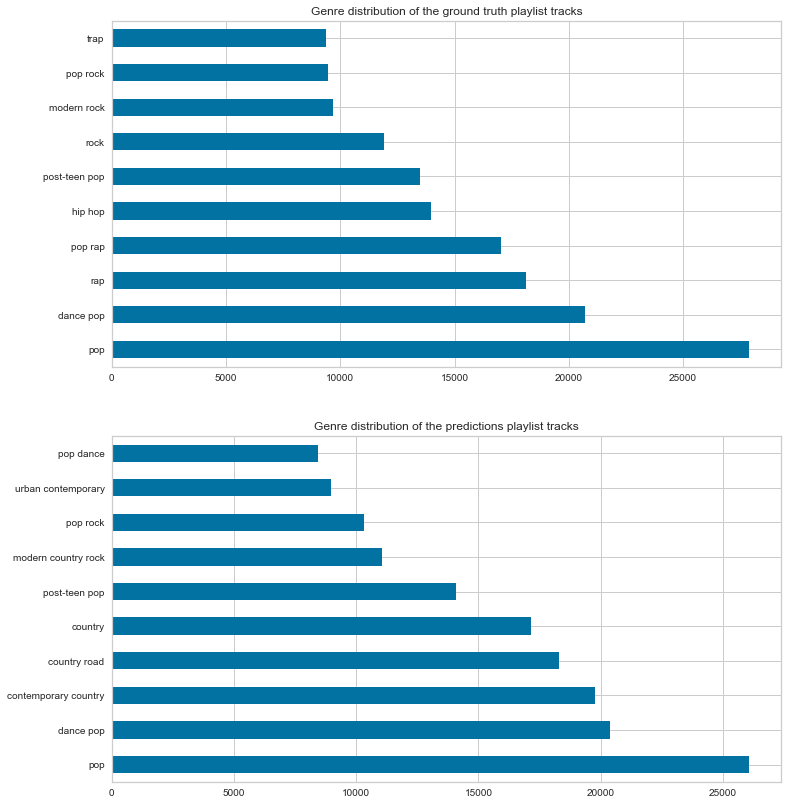

In [78]:
def plot_genre_distributions(preds_df, gt_df, use_avg=False):
    if use_avg:
        avg_gt_len = int(gt_df.groupby('pid').size().mean())
    else:
        avg_gt_len = len(gt_df)
    preds_df = preds_df.groupby('pid').head(avg_gt_len)
    truth_genres =  gt_df['genres'].str.split(',').explode().replace('', np.nan).dropna()
    prediction_set_genres =  preds_df.genres.str.split(',').explode().replace('', np.nan).dropna()
    plt.figure(figsize=(12,14))
    plt.subplot(211)
    plt.title('Genre distribution of the ground truth playlist tracks (Top 10)')
    truth_genres.value_counts()[:10].plot(kind='barh')
    plt.subplot(212)
    plt.title('Genre distribution of the predictions playlist tracks (Top 10)')
    prediction_set_genres.value_counts()[:10].plot(kind='barh')

plot_genre_distributions(test_predicted_playlist_tracks_genres_df,test_playlist_tracks_genres_df, use_avg=True)

In [12]:
model_eval = Evaluator(test_predicted_playlist_tracks_genres_df,test_playlist_tracks_genres_df)
model_eval.evaluate()

100%|██████████| 1988/1988 [00:21<00:00, 91.89it/s]


r_precision_tracks     0.001703
r_precision_artists    0.031481
r_precision_genres     0.362326
ndcg                   0.001799
songs_click            5.680231
dtype: float64

## Neural Network (NeuMF)

In [14]:
total_playlist_tracks_df = train_playlist_tracks_df.append(test_playlist_tracks_incomplete_df)
unique_tracks = total_playlist_tracks_df['tid'].unique()
total_cat_type = CategoricalDtype(categories=unique_tracks, ordered=True)
total_playlist_tracks_df['tid'] = total_playlist_tracks_df.tid.astype(total_cat_type)
total_playlist_tracks_df['cat_codes'] = total_playlist_tracks_df['tid'].cat.codes

dok_mat_n_rows = total_playlist_tracks_df.shape[0]
dok_mat_n_cols = len(unique_tracks)

dok_mat_rows = total_playlist_tracks_df['pid']
dok_mat_cols = total_playlist_tracks_df['cat_codes']

# Make a dictionary key sparse matrix
dok_mat = dok_matrix((dok_mat_n_rows, dok_mat_n_cols))

# TODO vectorize later if possible
for (pid, cat_code) in tqdm(zip(dok_mat_rows, dok_mat_cols)):
    dok_mat[pid, cat_code] = 1.0

575189it [00:07, 78884.51it/s]


In [15]:
rand_negative_fill_in = 4
layer_sizes = [64, 32, 16, 8]

# Hyperparameters
embedding_dim = 8
num_epochs = 2
learning_rate = 0.001
batch_size = 200

In [16]:
class NeuralMF(torch.nn.Module):
    def __init__(self, num_pl, num_tr, dim=embedding_dim):
        super(NeuralMF, self).__init__()
        num_of_layers = len(layer_sizes)
            
        self.pl_embedding = torch.nn.Embedding(num_pl, dim)
        self.tr_embedding = torch.nn.Embedding(num_tr, dim)
        self.pl_mlp_embedding = torch.nn.Embedding(num_pl, int(layer_sizes[0]/2))
        self.tr_mlp_embedding = torch.nn.Embedding(num_tr, int(layer_sizes[0]/2))
            
        self.mlp = torch.nn.ModuleList()
        for i in range(1, num_of_layers):
            self.mlp.append(torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            self.mlp.append(torch.nn.ReLU())

        self.affine_final = torch.nn.Linear(dim + layer_sizes[-1], 1)
        self.logistic_sig = torch.nn.Sigmoid()
    
    def init_weight(self):
        torch.nn.init.normal_(self.pl_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_embedding, std=0.01)
        torch.nn.init.normal_(self.pl_mlp_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_mlp_embedding, std=0.01)
        
        for layer in self.mlp:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                
        torch.nn.init.xavier_uniform_(self.affine_final.weight)
        
        for mod in self.modules():
            if isinstance(mod, torch.nn.Linear) and mod.bias is not None:
                mod.bias.data.zero_()
        
    def forward(self, playlists, tracks):
        pl_vec = self.pl_embedding(playlists)
        tr_vec = self.tr_embedding(tracks)
        prod = torch.mul(pl_vec, tr_vec)
        
        pl_mlp_vec = self.pl_mlp_embedding(playlists)
        tr_mlp_vec = self.tr_mlp_embedding(tracks)
        mlp_vec = torch.cat([pl_mlp_vec, tr_mlp_vec], dim=-1)
        
        for i, layer in enumerate(self.mlp):
            mlp_vec = layer(mlp_vec)
            
        result = self.affine_final(torch.cat([prod,mlp_vec], dim=-1))
        activated_result = self.logistic_sig(result)
        return torch.flatten(activated_result)

In [17]:
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1])
model.to(device)
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.title(f'Training Curve (batch_size={batch_size}, lr={learning_rate})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def make_train_data():
    for (pl, tr) in dok_mat.keys():
        yield pl, tr, 1.0
        for t in range(rand_negative_fill_in):
            rand_num = np.random.randint(dok_mat.shape[1])
            while(pl, rand_num) in dok_mat.keys():
                rand_num = np.random.randint(dok_mat.shape[1])
            yield pl, rand_num, 0.0

def train_loop(data_loader):
    losses = []; iters = []; offset = 0
    for epoch in range(num_epochs):
        for idx, (pl, tr, recs) in enumerate(tqdm(data_loader)):
            pl, tr, recs = pl.to(device), tr.to(device), recs.to(device)
            recs = recs.float()
            optim.zero_grad()
            out = model(pl,tr)
            loss = loss_fn(out, recs)
            losses.append(loss)
            iters.append(offset+idx)
            loss.backward()
            optim.step()
        offset = iters[-1]
        print(f'training loss after epoch-{epoch+1} = {(losses[-1]):.4f}')
    return iters, losses

def run_training():
    data_loader = torch.utils.data.DataLoader(list(make_train_data()), batch_size=batch_size)
    return train_loop(data_loader)

In [ ]:
iters, losses = run_training()
torch.save(model.state_dict(), MODEL_PATH)
plot_loss(iters, losses)

In [42]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device)) #👌 

<All keys matched successfully>

In [ ]:
summary(model, )

## Make recommendations using the NeuMF model

In [80]:
playlist_for_test = np.random.choice(test_playlist_tracks_df['pid'].tolist())
ground_truth = test_playlist_tracks_df[test_playlist_tracks_df['pid'] == playlist_for_test]

playlist_embedding_weight_matrix = model.pl_mlp_embedding.weight
chosen_playlist_vector = playlist_embedding_weight_matrix[playlist_for_test]

In [ ]:
# Hyperparameter Search
# NOTE: WILL TAKE AGES TO RUN
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(50,100))
visualizer.fit(playlist_embedding_weight_matrix.detach().cpu().numpy())
visualizer.show()

In [81]:
print("Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists")
km_model = KMeans(n_clusters=100, random_state=0, verbose=0).fit(playlist_embedding_weight_matrix.detach().cpu().numpy())

Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists


In [90]:
chosen_playlist_vector = chosen_playlist_vector.detach().cpu().numpy().reshape(1,-1)
playlist_predictor = km_model.predict(chosen_playlist_vector)
playlist_labels = km_model.labels_

similar_playlists = []
for pid, playlist_label in enumerate(playlist_labels):
    if playlist_label == playlist_predictor:
        similar_playlists.append(pid)
print(f'other playlists in cluster: {len(similar_playlists)}')

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [91]:
tracks = []
for pid in similar_playlists:
    tracks += list(total_playlist_tracks_df[total_playlist_tracks_df['pid'] == pid]['cat_codes'])
print(f'other tracks from similar_playlists in cluster: {len(tracks)}') 

tracks = list(OrderedDict.fromkeys(tracks))

pids_pred = torch.tensor(np.full(len(tracks), playlist_for_test, dtype='int32')).to(device)
tracks_pred = torch.tensor(np.array(tracks, dtype='int32')).to(device)
model.eval()
results = model(pids_pred, tracks_pred)
print("Retrieved predictions from trained model...")

other tracks from similar_playlists in cluster: 5387
Retrieved predictions from trained model...


In [92]:
unique_playlist_tracks_df = total_playlist_tracks_df.drop_duplicates(subset=['cat_codes'])
unique_playlist_tracks_df = unique_playlist_tracks_df.sort_values(by=['cat_codes'], ascending=False)

unique_tids_by_cat_codes = np.array(unique_playlist_tracks_df['tid'])
unique_result_merged = unique_playlist_tracks_df.merge(tracks_features_df, on='tid')
other_features_by_cat_codes = np.array([(row['track_name'],row['artist_name']) for i, row in unique_result_merged.iterrows()])

def get_results_df():
    for i, probability in enumerate(tqdm(results)):
        tid = unique_tids_by_cat_codes[i]
        other_features = other_features_by_cat_codes[i]
        yield probability.item(), tid, *other_features

results_df = pd.DataFrame(get_results_df(), index=range(len(results)), columns=['probability', 'tid','track_name', 'artist_name'])
results_df = results_df.sort_values(by=['probability'], ascending=False)

nmf_preds = results_df.head(len(ground_truth)-NUM_WITHHELD)
nmf_preds

100%|██████████| 4918/4918 [00:00<00:00, 42319.25it/s]


,probability,tid,track_name,artist_name
4683,0.956850,164723,BURY YOU (feat. The-Dream),SBTRKT
2419,0.954828,167315,Do You Hear What I Hear?,Kenny G
2408,0.952617,167326,Hot Boy,Bankroll Fresh
9,0.948883,170077,Beach Book,Bay Faction
661,0.947872,169332,Double Trouble,Beres Hammond
...,...,...,...,...
4545,0.914267,164889,"Ay, Ay, Ay It's Christmas",Ricky Martin
1717,0.914161,168131,Don't Want to Change Your Mind,FM-84
1873,0.913983,167944,Don't Say a Word,Major and the Monbacks
4348,0.913965,165121,I Can't Read Your Mind,Eric Chesser


In [93]:
def predictions_nmf():
    for idx,row in nmf_preds.iterrows():
        yield (row['tid'], playlist_for_test, idx)

predictions_nmf_df = pd.DataFrame(predictions_nmf(), columns=['tid','pid', 'pos'])

predictions_nmf_genres_df = predictions_nmf_df
temp_df = predictions_nmf_genres_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
predictions_nmf_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

ground_truth_genres_df = ground_truth.iloc[25:]
temp_df = ground_truth_genres_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
ground_truth_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

In [94]:
ground_truth_genres_df

,tid,uri,pid,pos,track_name,artist_name,genres
0,19757,spotify:track:0tkBOcK7oRVXQJY97zzSvr,9964,28,Telescope,Cage The Elephant,"indie rock,modern alternative rock,modern rock..."
1,63,spotify:track:00CqEmnPLFKDhAb3cuu6Cs,9964,30,Halo,Cage The Elephant,"indie rock,modern alternative rock,modern rock..."
2,31138,spotify:track:1PmaWG47wJRCIOM9v8Bauo,9964,31,Hypocrite,Cage The Elephant,"indie rock,modern alternative rock,modern rock..."
3,139080,spotify:track:6MtJnnoTMozorcmelPpy8Y,9964,32,Teeth,Cage The Elephant,"indie rock,modern alternative rock,modern rock..."
4,64891,spotify:track:2xrRBqEanoBaA0tOgYy18V,9964,33,The Three of Us,Streetlight Manifesto,"modern ska punk,punk,ska,ska punk,skate punk"
...,...,...,...,...,...,...,...
78,61214,spotify:track:2nLtzopw4rPReszdYBJU6h,9964,119,Numb,Linkin Park,"alternative metal,nu metal,post-grunge,rap metal"
79,166046,spotify:track:7oVEtyuv9NBmnytsCIsY5I,9964,120,BURN IT DOWN,Linkin Park,"alternative metal,nu metal,post-grunge,rap metal"
80,103963,spotify:track:4kfm1uI9QGaoN9qm6CkAMn,9964,121,What I've Done,Linkin Park,"alternative metal,nu metal,post-grunge,rap metal"
81,125960,spotify:track:5lJH3o6AFW9Aig1CdRdAF1,9964,122,Crossfire,Stephen,"bass trap,indie poptimism,la pop"


In [95]:
predictions_nmf_genres_df

,tid,pid,pos,track_name,artist_name,genres
0,164723,9964,4683,BURY YOU (feat. The-Dream),SBTRKT,"electronica,electropop,future garage,indie sou..."
1,167315,9964,2419,Do You Hear What I Hear?,Kenny G,"smooth jazz,smooth saxophone"
2,167326,9964,2408,Hot Boy,Bankroll Fresh,"atl hip hop,atl trap,deep southern trap,dirty ..."
3,170077,9964,9,Beach Book,Bay Faction,alternative emo
4,169332,9964,661,Double Trouble,Beres Hammond,"lovers rock,reggae,roots reggae"
...,...,...,...,...,...,...
78,164889,9964,4545,"Ay, Ay, Ay It's Christmas",Ricky Martin,"dance pop,latin,latin pop,mexican pop,puerto r..."
79,168131,9964,1717,Don't Want to Change Your Mind,FM-84,"popwave,synthwave"
80,167944,9964,1873,Don't Say a Word,Major and the Monbacks,
81,165121,9964,4348,I Can't Read Your Mind,Eric Chesser,


In [96]:
nmf_model_eval = Evaluator(predictions_nmf_genres_df, ground_truth_genres_df)
nmf_model_eval.evaluate()

100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


r_precision_tracks     0.000000
r_precision_artists    0.111111
r_precision_genres     0.465517
ndcg                   0.000000
songs_click            9.300000
dtype: float64

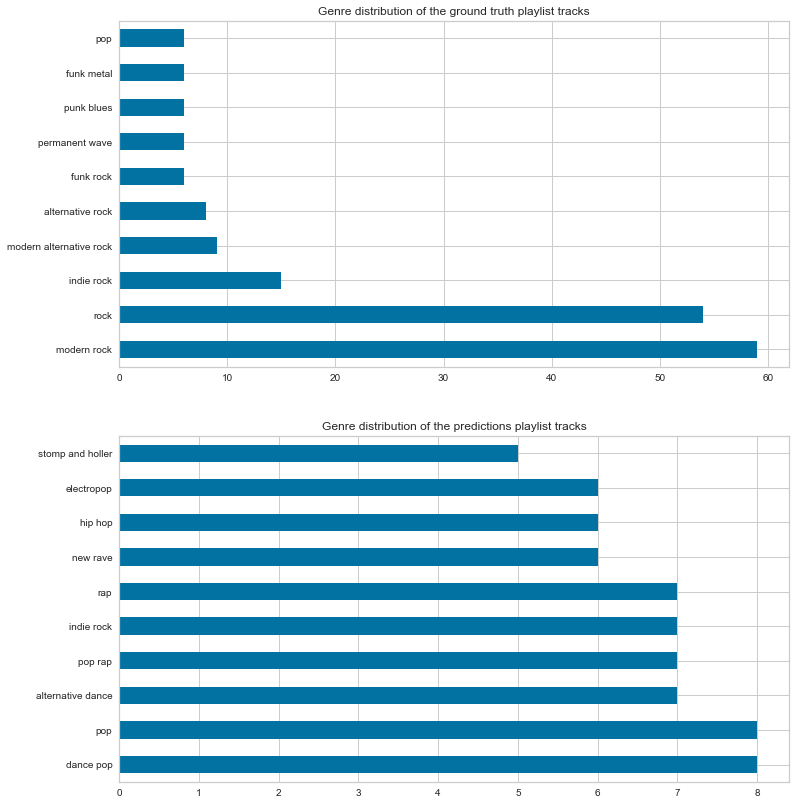

In [98]:
plot_genre_distributions(predictions_nmf_genres_df, ground_truth_genres_df)

In [ ]:
test_playlist_tracks_incomplete_df.query('pid == @playlist_for_test')[['tid','pos']].merge(tracks_features_df[['tid','artist_name','track_name']], on='tid')

In [ ]:
ground_truth[['tid','pos']].merge(tracks_features_df[['tid','artist_name','track_name']], on='tid')